# Diagnosis of a bad Digits classification - bias and variance

Make a Naive Bayes classifier for the Digits task, this uses an 8x8 greyscale of the digits 0-9, the task is to predict the correct label from the image.

Here we want to understand the bias/variance tradeoff. For each classifier we fit using progressively larger amounts of training data and score using a set-aside test set. We never vary the test set (and we don't use that data for training). The same test set is shared across all the classifiers, the same subsets of training data are used for each classifier (both using `RANDOM_STATE`).

Source:
* http://cs229.stanford.edu/materials/ML-advice.pdf

Classifiers:
* DummyClassifier
* BernoulliNaiveBayes
* LogisticRegression
* DecisionTree (using defaults)
* RandomForest (with defaults and a better set of hyperparamters)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn import naive_bayes

# let's plot inline
%matplotlib inline

# load the digits dataset
from sklearn.datasets import load_digits
digits = load_digits()

/home/ian/anaconda/envs/scratch/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# install watermark using
# %install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
# show a watermark for this environment
%watermark -d -m -v -p numpy,matplotlib -g

2016-02-15 

CPython 3.4.4
IPython 4.0.3

numpy 1.10.4
matplotlib 1.5.1

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.16.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 5dfc89186f0c0e532d663b92007a8b42684ab3cd


In [3]:
# start a separate QTconsole for interactive coding
#%qtconsole

In [4]:
# flatten and binarise the 2D input image - this is our basic feature set
# we could improve the features here by adding new columns to X
arr_digits_greyscale = [digit.flatten() for digit in digits.images]
arr_digits = [digit.flatten()>=8 for digit in digits.images]
X_greyscale = np.vstack(arr_digits_greyscale)
X = np.vstack(arr_digits)
y = digits.target
print("X has shape {}, y has shape {}".format(X.shape, y.shape))

X has shape (1797, 64), y has shape (1797,)


# Split the original data into a validation set (for scoring) and a training set

In [5]:
# We'll fix a random seed so the results are the same on each run,
# you wouldn't do this in practice but it does help when you're debugging
RANDOM_STATE = 43

test_size = 0.1 # validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

In [6]:
# now take n% from X_train, train on this, then test on all of y_train
train_set_sizes = np.arange(0.01, 1.0, 0.01)

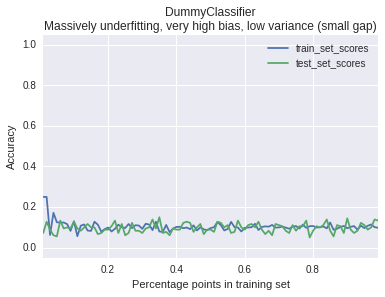

In [7]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = DummyClassifier()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("DummyClassifier\nMassively underfitting, very high bias, low variance (small gap)")

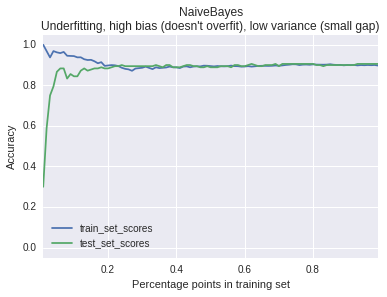

In [8]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = naive_bayes.BernoulliNB()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("NaiveBayes\nUnderfitting, high bias (doesn't overfit), low variance (small gap)")

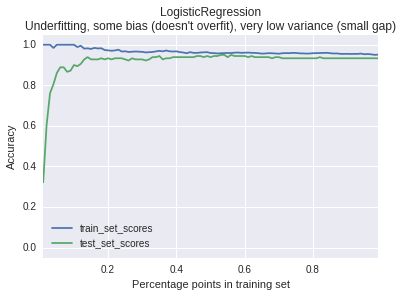

In [9]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = linear_model.LogisticRegression()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("LogisticRegression\nUnderfitting, some bias (doesn't overfit), very low variance (small gap)")

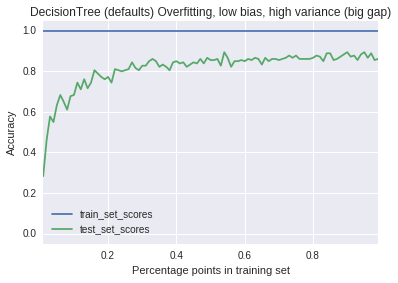

In [10]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = tree.DecisionTreeClassifier()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("DecisionTree (defaults) Overfitting, low bias, high variance (big gap)")

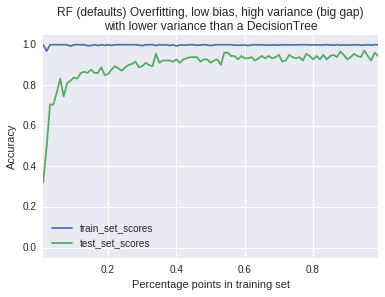

In [11]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

clf = RandomForestClassifier()

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("RF (defaults) Overfitting, low bias, high variance (big gap)\nwith lower variance than a DecisionTree")

## Hyperparameter optimisation

Use `GridSearchCV` to search a 2D grid of parameters (`n_estimators` and `max_depth`), visualise the scores obtained for the Cartesian Product of all combinations in a 2D plot. We use one of the best results to fit a final `RandomForestClassifier` using better hyperparameters and visualise the final result. 

In [24]:
from operator import itemgetter

def report(grid_scores, n_top=3):
    # TODO put in attrib to sklearn demo
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [25]:
# TODO Ian - this code is clunky, think on a cleaner implementation!

def convert_grid_search_into_df(grid_search, param_grid):
    """Convert 2D grid_search results into 2D DataFrame"""
    keys = list(param_grid.keys())
    assert len(keys) == 2 # we can only plot 2D
    x_key = keys[0]
    y_key = keys[1]
    x_steps = param_grid[x_key]
    y_steps = param_grid[y_key]
    scores_arr = np.zeros((x_steps.shape[0], y_steps.shape[0]))
    for grid_result in grid_search.grid_scores_:
        params = grid_result.parameters
        x_value = params[x_key]
        x_idx = np.where(x_steps==x_value)[0][0]
        y_value = params[y_key]
        y_idx = np.where(y_steps==y_value)[0][0]    
        scores_arr[x_idx, y_idx] = grid_result.mean_validation_score

    df_hyperparameters = pd.DataFrame.from_records(scores_arr.T, columns=[x_steps], index=[y_steps])
    return df_hyperparameters

In [35]:
from sklearn.grid_search import GridSearchCV

param_grid = {'n_estimators': np.arange(1, 10, 1),
              'max_depth': np.arange(1, 10, 1)}

clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [36]:
report(grid_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.912 (std: 0.013)
Parameters: {'n_estimators': 7, 'max_depth': 9}

Model with rank: 2
Mean validation score: 0.909 (std: 0.007)
Parameters: {'n_estimators': 7, 'max_depth': 8}

Model with rank: 3
Mean validation score: 0.909 (std: 0.012)
Parameters: {'n_estimators': 9, 'max_depth': 8}



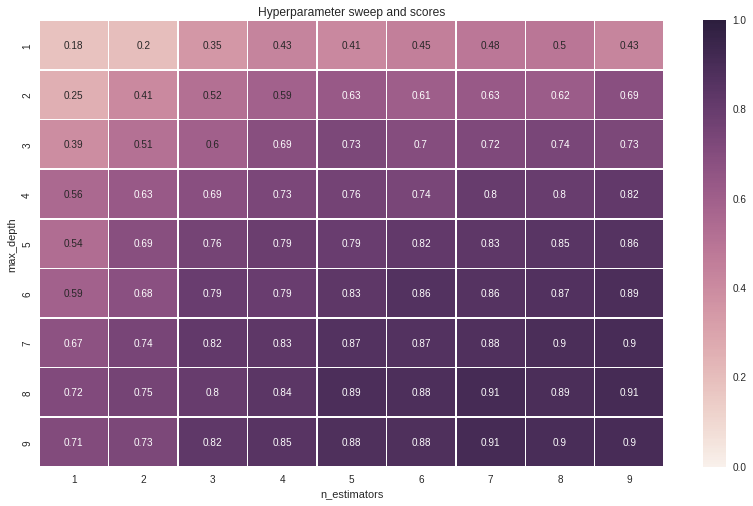

In [37]:
df_hyperparameters = convert_grid_search_into_df(grid_search, param_grid)

f, ax=plt.subplots(1, 1, figsize=(14,8))
sns.heatmap(df_hyperparameters, annot=True, linewidths=.5, ax=ax, vmin=0, vmax=1.0)
plt.xlabel(x_key)
plt.ylabel(y_key)
plt.title("Hyperparameter sweep and scores")

### Search on a larger grid for high-scoring hyperparameters

We can see that increasing the `max_depth` doesn't help, we don't improve the score after a depth of 20 or so decisions (given this feature set and number of examples). By increasing the number of trees we can make impressively high scores even with a `max_depth` of `1`. Our best scores top out at approximately `0.96`.

In [74]:
# scan from 1..100 with log-scaled increments
param_grid = {'n_estimators': np.logspace(0.2, 3, num=10, dtype=np.int_),
              'max_depth': np.logspace(0.2, 1.7, num=10, dtype=np.int_)} 

clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([   1,    3,    6,   13,   27,   56,  116,  238,  488, 1000]), 'max_depth': array([ 1,  2,  3,  5,  7, 10, 15, 23, 34, 50])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [78]:
report(grid_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.962 (std: 0.002)
Parameters: {'n_estimators': 238, 'max_depth': 15}

Model with rank: 2
Mean validation score: 0.962 (std: 0.002)
Parameters: {'n_estimators': 488, 'max_depth': 23}

Model with rank: 3
Mean validation score: 0.962 (std: 0.002)
Parameters: {'n_estimators': 238, 'max_depth': 50}



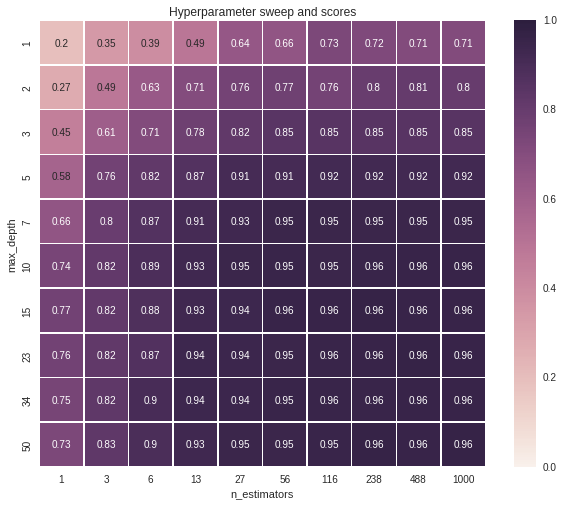

In [76]:
df_hyperparameters = convert_grid_search_into_df(grid_search, param_grid)

f, ax=plt.subplots(1, 1, figsize=(10,8))
sns.heatmap(df_hyperparameters, annot=True, linewidths=.5, ax=ax, vmin=0, vmax=1.0)
plt.xlabel(x_key)
plt.ylabel(y_key)
plt.title("Hyperparameter sweep and scores")

### Finish with a strong RandomForest using tuned hyperparameters

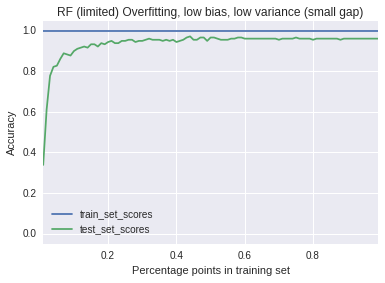

In [79]:
training_set_scores = np.zeros_like(train_set_sizes)
test_set_scores = np.zeros_like(train_set_sizes)

# note the hyperparameters were chosen using the process in the hyperparameter section
# generally you'd pick the highest-scoring configuration that's built in the least expensive
# way (i.e. fewest estimators and least depth) for speed of execution and higher likelihood
# of generalising to unseen future data
clf = RandomForestClassifier(n_estimators=238, max_depth=15)

for training_set_idx, train_set_size in enumerate(train_set_sizes):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-train_set_size, random_state=RANDOM_STATE)

    clf.fit(X_train_subset, y_train_subset)
    train_score = clf.score(X_train_subset, y_train_subset)
    training_set_scores[training_set_idx] = train_score
    
    test_score = clf.score(X_test, y_test)
    test_set_scores[training_set_idx] = test_score

df_scores = pd.DataFrame({'idx': train_set_sizes, 'test_set_scores': test_set_scores, 'train_set_scores': training_set_scores})
df_scores = df_scores.set_index('idx')
df_scores = df_scores[['train_set_scores', 'test_set_scores']] # reorder columns

df_scores.plot()
plt.ylim((-0.05, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Percentage points in training set")
plt.title("RF (limited) Overfitting, low bias, low variance (small gap)")

# Next steps

* http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html perhaps try a Partial Dependence plot
* record execution time for each param pair in hyperparameter sweep, do a 2nd plot showing time-cost to calculate each version - is it more expensive to build deeper trees or to add more trees?